In [1]:
#导入要用到的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [2]:
#读取数据和停用词表
df=pd.read_csv('news_train.csv',encoding="gb18030",index_col=0)
stop_list=pd.read_csv('中文停用词.txt',encoding='utf-8',sep='\t',names=['stop_list'],quoting=3)

In [3]:
#切分文本 去停用词 让文本只保留汉字
def text_cut(sentence):
    sen_cut=jieba.lcut(sentence)
    sen_cut=[w for w in sen_cut if (w not in stop_list.values) and (w >=u'\u4e00' and w<= u'\u9fa5')]
    return " ".join(sen_cut)#用空格隔开
    
df['cutlist']=df['新闻'].apply(text_cut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\陈欣禧\AppData\Local\Temp\jieba.cache
Loading model cost 0.669 seconds.
Prefix dict has been built successfully.


In [4]:
#划分数据集
training_size=8000
train_X=df['cutlist'][:training_size].values#ndarry
train_Y=df['标签'][:training_size].values
val_X=df['cutlist'][training_size:].values
val_Y=df['标签'][training_size:].values

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
#用训练集和tokenize生成一个字典（样子是--词：标号）设置字典最大长度，并加一个<oov>当遇到不在字典里的词就用它对应的数字标号
max_words=119000
tokenizer=Tokenizer(num_words=max_words,oov_token='<oov>')
tokenizer.fit_on_texts(train_X)#fit_on_texts是适配文本，给了文本一个编号和统计（文本还是文本）

word_index=tokenizer.word_index#返回值是字典

training_sequences=tokenizer.texts_to_sequences(train_X)#list #texts_to_sequences是文本变数字序列
training_padded=pad_sequences(training_sequences,maxlen=300,padding='post',truncating='post')#裁剪成同等长度(8000,300)

In [7]:
#把标签列用onehot表示 fit的时候用
from tensorflow.keras.utils import to_categorical
train_Y_onehot=to_categorical(train_Y)
val_Y_onehot=to_categorical(val_Y)

In [8]:
#把验证集变成序列并裁剪长度
val_sequences=tokenizer.texts_to_sequences(val_X)#list
val_padded=pad_sequences(val_sequences,maxlen=300,padding='post',truncating='post')

In [9]:
#把tokenizer生成的字典的键值对换位置，可以用来把我们的数字序列转化回文本序列 可以用来检验一下有没有出错
reverse_word_index = dict([(value,key)for(key,value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i) for i in text])

In [10]:
#验证一下有没有出错
decode_review(val_sequences[0]),val_X[0]#传入的是 没裁剪前 的数字序列

('中国 四所 高校 <oov> 全球 强 港大 亚洲 第一 本报 香港 月 日电 记者 <oov> 国际 高等教育 调查 机构 今日 公布 世界 大学排名 最新 榜单 香港大学 香港科技大学 香港中文大学 北京大学 世界排名 前 清华大学 位列 <oov> 位 <oov> 位列 第九 <oov> 香港大学 首超 东京大学 位列 亚洲 大学 首位 排名 大学 研究 素质 雇主 评价 师生 国际化 程度 论文 引用 情况 排名 准则 高 权威性 榜单 剑桥 荣登榜首 哈佛 和耶鲁 紧随其后 中国 北大 去年 名 排名 <oov> 清华 台大 去年 名次 相比 差距 港大 延续 去年 升势 位列 第二十三 科大 微跌 名 位列 <oov> 港 <oov> 扭转 跌势 攀升 <oov> 位',
 '中国 四所 高校 跻入 全球 强 港大 亚洲 第一 本报 香港 月 日电 记者 黄拯 国际 高等教育 调查 机构 今日 公布 世界 大学排名 最新 榜单 香港大学 香港科技大学 香港中文大学 北京大学 世界排名 前 清华大学 位列 第五十四 位 台湾大学 位列 第九 十四名 香港大学 首超 东京大学 位列 亚洲 大学 首位 排名 大学 研究 素质 雇主 评价 师生 国际化 程度 论文 引用 情况 排名 准则 高 权威性 榜单 剑桥 荣登榜首 哈佛 和耶鲁 紧随其后 中国 北大 去年 名 排名 第四十七 清华 台大 去年 名次 相比 差距 港大 延续 去年 升势 位列 第二十三 科大 微跌 名 位列 第四十 港 中大则 扭转 跌势 攀升 第四十二 位')

In [15]:
#开始搭建模型！
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Embedding,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Dense,concatenate,Flatten,Dropout,GlobalMaxPooling1D
from keras import regularizers
from keras import activations

In [56]:
#超参数
max_len=300
embedding_dim=128
hidden_dim=128
num_labels=10
filters=32
max_words=119000
window_size=[3,4,5]
pool_size=2
batch_size=32

In [57]:
#输入的形状考虑的是一段文本 即他的长度
inputs = Input(shape=[max_len,],dtype='float64')
Embed = Embedding(max_words,output_dim=embedding_dim,input_length=max_len)(inputs)
#用了大小分别为3，4，5的卷积核大小 
cnn1=Conv1D(filters,3,padding='same',activation='tanh')(Embed)
cnn1=MaxPooling1D(pool_size=pool_size)(cnn1)
#cnn1=GlobalMaxPooling1D()(cnn1)
cnn2=Conv1D(filters,4,padding='same',activation='tanh')(Embed)
cnn2=MaxPooling1D(pool_size=pool_size)(cnn2)
#cnn2=GlobalMaxPooling1D()(cnn2)
cnn3=Conv1D(filters,5,padding='same',activation='tanh')(Embed)
#cnn3=GlobalMaxPooling1D()(cnn3)
cnn3=MaxPooling1D(pool_size=pool_size)(cnn3)

cnn=concatenate([cnn1,cnn2,cnn3],axis=-1)

x=Flatten()(cnn)
x=Dense(hidden_dim,activation='relu',kernel_regularizer=regularizers.L2(1e-4))(x)


x=Dropout(0.01)(x)
output=Dense(num_labels+1,activation='softmax')(x)

model=Model(inputs,output)

In [58]:
#编译
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['acc'])

In [59]:
path_to_my_tf_CP='weigths-improvement-{epoch:02d}-{val_acc:.2f}.h5'
#保留最佳模型
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='acc',patience=1),
    #keras.callbacks.ModelCheckpoint(filepath=path_to_my_tf_CP,monitor='val_loss',save_best_only=True)
]

In [60]:
#拟合
num_epochs=20
history=model.fit(training_padded,train_Y_onehot,epochs=num_epochs,validation_data=(val_padded,val_Y_onehot),callbacks=[callbacks_list],batch_size=batch_size)

Epoch 1/20
250/250 [==============================] - 21s 79ms/step - loss: 0.6956 - acc: 0.7894 - val_loss: 0.2144 - val_acc: 0.9500
Epoch 2/20
250/250 [==============================] - 22s 88ms/step - loss: 0.0861 - acc: 0.9872 - val_loss: 0.2026 - val_acc: 0.9490
Epoch 3/20
250/250 [==============================] - 19s 78ms/step - loss: 0.0310 - acc: 0.9967 - val_loss: 0.1917 - val_acc: 0.9460
Epoch 4/20
250/250 [==============================] - 19s 78ms/step - loss: 0.0179 - acc: 0.9981 - val_loss: 0.1998 - val_acc: 0.9525
Epoch 5/20
250/250 [==============================] - 19s 78ms/step - loss: 0.0138 - acc: 0.9979 - val_loss: 0.2348 - val_acc: 0.9450


In [61]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 300, 128)     15232000    ['input_6[0][0]']                
                                                                                                  
 conv1d_15 (Conv1D)             (None, 300, 32)      12320       ['embedding_5[0][0]']            
                                                                                                  
 conv1d_16 (Conv1D)             (None, 300, 32)      16416       ['embedding_5[0][0]']            
                                                                                            

In [25]:
#评估
def plot_graphs(history,string):
    plt.figure(figsize=(4,3))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epoch')
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()

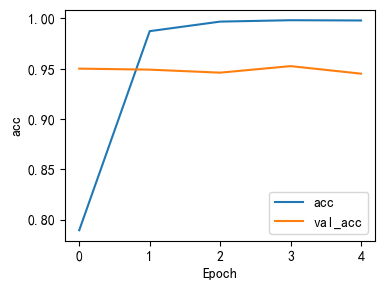

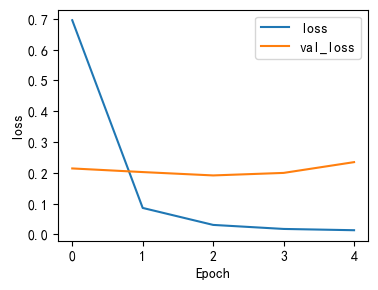

In [62]:
plot_graphs(history,'acc')
plot_graphs(history,'loss')

In [27]:
#保存模型
model.save_weights('4_28model_weights.h5')

In [63]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [64]:
val_pred=model.predict(val_padded)

63/63 [==============================] - 1s 17ms/step


[[192   0   1   0   0   0   0   1   1   0]
 [  0 194   3   7   7   1   1   1   2   1]
 [  0   0 188   0   0   0   2   0   0   0]
 [  0   4   2 174   2   1   5   5   1   0]
 [  3   0   6   0 187   0   0   0   0   1]
 [  0   1   2   0   1 209   4   2   1   0]
 [  3   0   2   3   1   0 191   1   2   0]
 [  2   4   0   3   0   2   0 184   0   1]
 [  1   0   7   0   3   2   3   0 184   0]
 [  0   0   0   0   0   0   0   1   0 187]]


Text(46.40625, 0.5, 'true_label')

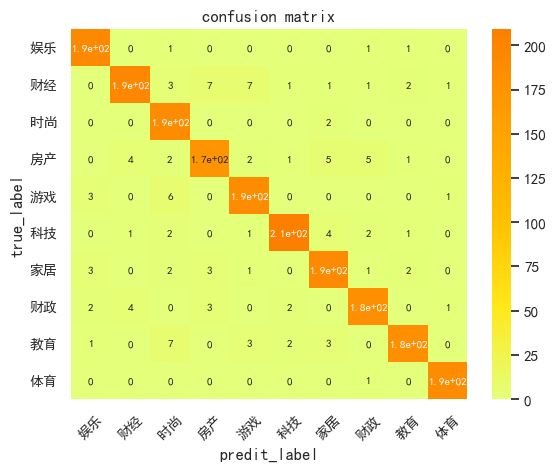

In [65]:
y_pred=tf.argmax(val_pred,axis=1)
y_pred=y_pred.numpy()
sns.set(font='SimHei')
f,ax=plt.subplots()
y_true=val_Y
cm=confusion_matrix(y_true,y_pred)
print(cm)
sns.heatmap(cm,annot=True,annot_kws={'size':8},ax=ax,xticklabels=["娱乐",'财经','时尚','房产','游戏','科技','家居','财政','教育','体育'],yticklabels=["娱乐",'财经','时尚','房产','游戏','科技','家居','财政','教育','体育'],cmap='Wistia')
plt.xticks(rotation=45,fontsize=10)
plt.yticks(rotation=0,fontsize=10)
ax.set_title('confusion matrix')
ax.set_xlabel('predit_label')
ax.set_ylabel('true_label')